## Lab 11. $\chi^2$ tests and Review.
The chi-squared test is the second to last test you're learning this semester. (*YAY!*) On that note, we're really winding down now, and this is the last real lab section.

### Goals.
1. Use `tibble()` and `tribble()`.
2. Conduct a chi-squared goodness-of-fit (a $\chi^2$ GOF) test.  
3. Conduct a chi-squared test for independence.  
4. Learn the relationship between a z-test for 2 proportions and a chi-squared test on a 2x2 table.

# 1. Quick note on `tibble()` and `tribble()`.

In [1]:
library(tibble)

In [11]:
tibble(name        = c("Arya",        "Daenerys"   ,  "Sansa"     ,  "Brienne"),
       origin      = c("Winterfell",  "Dragonstone",  "Winterfell",  "Tarth"  ),
       occupation  = c("Swordswoman", "Queen"      ,  "Lady"      ,  "Swordswoman"),
       seasons     = c(8            ,  8           ,   8          ,   8        ))

name,origin,occupation,seasons
Arya,Winterfell,Swordswoman,8
Daenerys,Dragonstone,Queen,8
Sansa,Winterfell,Lady,8
Brienne,Tarth,Swordswoman,8


In [9]:
tribble( ~Cersei,  ~Tyrion,
         "Queen",  "Hand of the other queen",
         "Evil",   "Short")

Cersei,Tyrion
Queen,Hand of the other queen
Evil,Short


# 2. Goodness-of-fit test example on size recommendation system.
Sometimes, we would like to know if counts of data follow a certain distribution. That is, we would like to ask the question of: **did the data I observe come from the distribution I have hypothesized?**

The data we are working are about Modcloth's clothing size recommendation system. We are going to look at the counts of how many of their recommendations fit, were too large, or were too small for the customer.

Let's `read_csv()` in our data!

In [109]:
library(readr, warn.conflicts=FALSE)
modcloth <- read_csv("modcloth.csv")

Parsed with column specification:
cols(
  item_id = col_integer(),
  waist = col_integer(),
  size = col_integer(),
  quality = col_integer(),
  `cup size` = col_character(),
  hips = col_double(),
  `bra size` = col_integer(),
  category = col_character(),
  bust = col_integer(),
  height = col_character(),
  user_name = col_character(),
  length = col_character(),
  fit = col_character(),
  user_id = col_integer(),
  `shoe size` = col_double(),
  `shoe width` = col_character(),
  review_summary = col_character(),
  review_text = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 2)”Warning message:
“1 parsing failure.
row # A tibble: 1 x 5 col     row col   expected               actual file           expected   <int> <chr> <chr>                  <chr>  <chr>          actual 1 37314 bust  no trailing characters -39    'modcloth.csv' file # A tibble: 1 x 5
”

Next, I'm using some normal `dplyr` functions like `filter()` and `select()`.

In [110]:
library(dplyr, warn.conflicts=FALSE)
modcloth <- modcloth %>% filter(category %in% c("bottoms", "tops"))
modcloth <- modcloth %>% select(category, fit)

Here's a small preview of our data using `sample_n()`.

In [111]:
modcloth %>% sample_n(5)

category,fit
bottoms,small
bottoms,small
tops,large
tops,large
bottoms,large


### Distribution of observed counts $O_i$.
Now, let's use the table function to see how our **counts** are distributed.

In [112]:
o_i <- table(modcloth$fit)
o_i


  fit large small 
24158  6226  5246 

Just out of interest, let's see what our **sample proportions** are.

In [113]:
sample_props <- counts_table / nrow(modcloth)
sample_props


      fit     large     small 
0.6780241 0.1747404 0.1472355 

When you're working on an algorithm that will recommend clothes, of course we would want all the clothes to fit all the customer we're recommending to! However, this can't always be the case. One size does not fit all!

Say that Modcloth wanted to maintain a **probability distribution** of:

$P(\text{Fit})   = 0.75$  
$P(\text{Large}) = 0.125$  
$P(\text{Small}) = 0.125$

Therefore, we'd have the **hypotheses**:

$H_0:$ Our counts data follow the prespecified distribution where $P(\text{Fit}) = 0.75$, $P(\text{Large}) = 0.125$, and $P(\text{Small}) = 0.75$.  
$H_1:$ At least one of our counts do not follow the distribution.  

Now, we'll start our $\chi^2$ test for goodness-of-fit. 

1. The assumptions for a goodness-of-fit test is that we have an independent random sample (we'll assume this), and at least 80% of our cells have $\geq 5$ counts in them.

2. Now, we would like to create our $\chi^2$ test statistic $\sum_{i=1}^{k} \frac{[O_i-E_i]^2}{E_i}$.


### Calculating expected counts $E_i$.
We need to calculate $E_i$. We will calculate $E_i$ by multiplying each of the probabilities from the probability distribution times our sample size $n$.

In [36]:
n <- nrow(modcloth)

In [42]:
dist <- c(fit=0.75, large=0.125, small=0.125)
e_i  <- n*dist
e_i

fit    large    small 
26722.50  4453.75  4453.75

### Calculating our test statistic.
Now that we have our $E_i$, we can do our subtraction, squaring, division, and then finally sum up all our terms. I'll show this step-by-step. You only need to really do the last step.

In [43]:
o_i-e_i


     fit    large    small 
-2564.50  1772.25   792.25 

In [44]:
(o_i-e_i)^2


      fit     large     small 
6576660.2 3140870.1  627660.1 

In [45]:
(o_i-e_i)^2 / e_i


     fit    large    small 
246.1095 705.2192 140.9284 

In [48]:
# * THIS CALCULATES THE FULL TEST STATISTIC
test_statistic_1 <- sum((o_i-e_i)^2 / e_i)
test_statistic_1

[1] 1092.257

We'll now want to calculate the p-value using `pchisq(test_statistic, degrees_of_freedom, lower.tail=FALSE)`. You will replace the values as fits your problem. For our problem,

- Our test statstic is $\chi^2=1092.2571$.  
- Our degrees of freedom, by definition, is $df=(k-1)=2$.
- For these tests, we will *always* use `lower.tail=FALSE`.

In [49]:
pchisq(q=test_statistic_1, df=2, lower.tail=FALSE)

[1] 6.597495e-238

That is a super small p-value!

### Confirming our answer using an `R` function.
We can also use the following `R` function to verify our answer.

In [114]:
chisq.test(x=o_i, 
           p=c(0.75, 0.125, 0.125))


	Chi-squared test for given probabilities

data:  o_i
X-squared = 1092.3, df = 2, p-value < 2.2e-16


We got the same test statistic and degrees of freedom. Perfect! Now, it's up to you to interpret our p-value and conclude our statistical test. Do we reject or fail to reject the notion that our counts come from the prespecified distribution?

#  3. Independence test example.
Imagine now that we're interested in seeing how our size recommendation system works for tops and for bottoms. We are now asking the question **are the distribution of clothing fits different or the same depending on which article of clothing the system recommends**?

Therefore, our **hypotheses** of interest are

$H_0$: Clothing fit and article type are independent (or: the distribution of clothing fit for bottoms is the same as that of tops.)  
$H_1$: They are dependent.

### Working with our $O_i$.
We already have our data loaded in, so what's next is that I'm going to `filter` some data just to remove the `NA` values, then make a table for our $O_i$.

In [144]:
modcloth     <- modcloth %>% filter(!is.na(fit)) %>% filter(!is.na(category))
o_i <- o_ip  <- table(modcloth$fit, modcloth$category)
o_i

       
        bottoms  tops
  fit     10660 13498
  large    2058  4168
  small    2548  2698

The table setup above looks familiar, right? We've been working with tables like these to calculate conditional probabilities. Let's make a dataframe that we can work with.

**In the following steps, I am reformatting our `o_i` so we can use it conveniently in `R`.** I am going to overwrite our original `o_i`. I am adding row names for our learning convenience (apparently, `tibble`s don't need row names anymore? I think they're helpful for a lot though!)

In [145]:
o_i <- tibble(bottoms = c(10660, 2058, 2548),
              tops    = c(13498, 4168, 2698))
row.names(o_i) <- c("fit", "large", "small")
o_i

Warning message:
“Setting row names on a tibble is deprecated.”

,bottoms,tops
fit,10660,13498
large,2058,4168
small,2548,2698


Before we get going, let's see if our distributions already look pretty different on a graph (so that we won't be surprised by our test results).

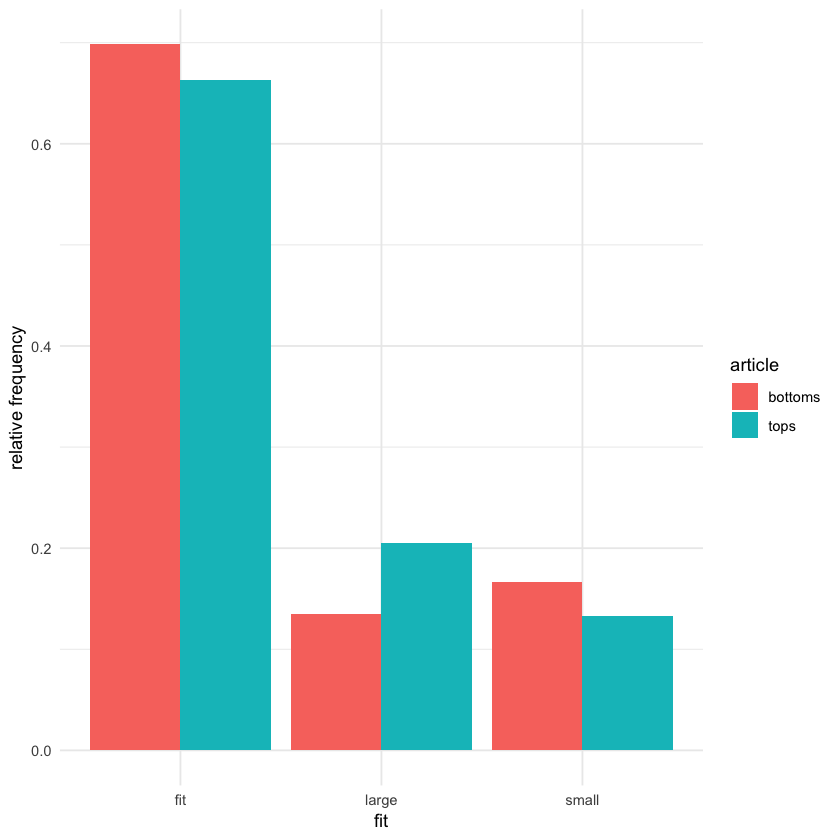

In [146]:
library(ggplot2)
o_ip <- data.frame(o_ip)
o_ip <- o_ip %>% rename(fit=Var1, article=Var2)
o_ip <- o_ip %>% mutate(relative_freq=Freq/rep(c(10660+2058+2548, 13498+4168+2698), each=3))
ggplot(o_ip, aes(x=fit, y=relative_freq, fill=article)) + 
    geom_bar(stat="identity", position="dodge") +
    ylab("relative frequency") +
    theme_minimal()

We see now that there is somewhat of a difference for bottoms/tops when it comes to large and small fits. However, the fit column seems to be quite similar for both article clothing types.

**Next, I'll reformat `o_i` to fit our coding needs.** Here, I'm adding a column for the row totals.

In [70]:
o_i <- cbind(o_i, totals=rowSums(o_i))
o_i

,bottoms,tops,totals
fit,10660,13498,24158
large,2058,4168,6226
small,2548,2698,5246


Lastly, I'm adding in my column totals!

In [71]:
o_i <- rbind(o_i, totals=colSums(o_i))
o_i

,bottoms,tops,totals
fit,10660,13498,24158
large,2058,4168,6226
small,2548,2698,5246
totals,15266,20364,35630


### Calculating our $E_i$.
In order to calculate our $E_i$, we use the formula

$$
E_i = \frac{[\text{Row total}]*[\text{Column total}]}{N}
$$

where $N$ is the grand total counts. There are other ways to do this, but this is easiest. Let's do the value for the first cell "by hand" in the chunk below.

In [74]:
fit_bottoms <- (15266*24158) / 35360
fit_bottoms

[1] 10429.75

Let's do it also for small tops.

In [75]:
small_tops <- (5246*20364) / 35360
small_tops

[1] 3021.198

The rest I'll do using code. (For you, continue using the formula above.)

In [87]:
e_i <- sapply(1:2, function(x) o_i[4,x]*o_i[1:3,3] / 35360)
e_i

10429.752,13912.712
2687.956,3585.584
2264.860,3021.198


And there are our expected values!

### Calculating our test statistic.
I'm going to first cut down `o_i` to its original size. We're done using the row and column totals.

In [90]:
o_i <- o_i[1:3, 1:2]
o_i

,bottoms,tops
fit,10660,13498
large,2058,4168
small,2548,2698


Here's our test statistic.

In [91]:
# * THIS CALCULATES THE FULL TEST STATISTIC
test_statistic_2 <- sum((o_i-e_i)^2 / e_i)
test_statistic_2

[1] 329.6572

Here's our p-value!

In [92]:
pchisq(q=test_statistic_2, df=(nrow(o_i)-1)*(ncol(o_i)-1), lower.tail=FALSE)

[1] 2.605198e-72

### Verifying our answer with an `R` function.
Our test statistic is very close to what was given from the below `R` function output.

In [96]:
chisq.test(x=o_i, correct=FALSE)


	Pearson's Chi-squared test

data:  o_i
X-squared = 330.1, df = 2, p-value < 2.2e-16


Now, it's up to you to interpret and conclude!

# 4. From z to $\chi^2$
Plenty of times in stats, some of our problems reduce into simpler ones. So is true for the story of $\chi^2$ and the z-test for 2 proportions. 

Let's start with just the following data. (It's a subset from earlier.)

In [157]:
unfit <- o_i[2:3,]
unfit <- cbind(unfit, totals=rowSums(unfit))
unfit <- rbind(unfit, totals=colSums(unfit))
row.names(unfit) <- c("large", "small", "totals")
unfit

,bottoms,tops,totals
large,2058,4168,6226
small,2548,2698,5246
totals,4606,6866,11472


### $\chi^2$ for independence.

Imagine we are interested in testing the following hypotheses:

$H_0$: The distribution of clothing fit is the same for each article of clothing.  
$H_1$: The distribution of clothing fit is not the same for each article of clothing. 

This is a $\chi^2$ test for independence.

In [161]:
chisq.test(o_i[2:3,],)


	Pearson's Chi-squared test with Yates' continuity correction

data:  o_i[2:3, ]
X-squared = 284.57, df = 1, p-value < 2.2e-16


From the above, we got a $\chi^2$ test statistic of $284.57 \approx 285$. Our p-value is very small. We would reach the conclusion of rejecting $H_0$. (Be able to interpret this in context!)

### 2 proportion z-test.
But what we can also do is take sample proportions and test those to be equal. The above $\chi^2$ test is equivalent to a 2 proportion z-test for $P(\text{Large}|\text{Tops})$ and $P(\text{Large}|\text{Bottoms})$. We don't have to test for $P(\text{Small}|\text{Tops})$ and $(\text{Large}|\text{Bottoms})$ because we can calculate these values using the complement rule.

$H_0$: $P(\text{Large}|\text{Tops}) = P(\text{Large}|\text{Bottoms})$  
$H_1$: $P(\text{Large}|\text{Tops}) \neq P(\text{Large}|\text{Bottoms})$  

Again, this is a 2 sample z-test for proportions.

In [167]:
p_large_tops <- 4168/6866
p_large_bots <- 2058/4606
p_large <- (4168+2058) / (6866+4606)

c(prop_large_tops    = p_large_tops, 
  prop_large_bottoms = p_large_bots,
  prop_large = p_large)

prop_large_tops prop_large_bottoms         prop_large 
         0.6070492          0.4468085          0.5427127

Off the bat, these proportions don't look quite the same. Let's see if statistical tests follow this thought.

In [169]:
numerator   <- p_large_tops-p_large_bots
denominator <- sqrt(p_large*(1-p_large)*((1/6866)+(1/4606)))
z_statistic <- numerator / denominator
z_statistic

[1] 16.88837

We can now calculate our p-value using `pnorm()`. Since it's a two-sided hypothesis test, I'm multiplying by 2.

In [173]:
2*(1-pnorm(q=z_statistic, mean=0, sd=1))

[1] 0

With a small p-value like that, we're going to follow the $\chi^2$ test's suit and reject $H_0$. So, while the p-values for the tests are possibly different, the two tests bring us to the same conclusion. We have evidence to believe the (1) distributions are not the same, which can also be restated as, (2) $P(\text{Large}|\text{Tops}) \neq P(\text{Large}|\text{Bottoms})$.  

Furthermore, while this may seem like a pop fact of sorts, the $\chi^2$ test statistic is simply the z-test statistic squared.

In [171]:
z_statistic^2

[1] 285.2169

Recall, the $\chi^2$ test statistic $\approx 285$, and $z^2 \approx 285$ as well. (There is some rounding error involved here.) This comes from some theory! The $\chi^2$ distribution is mathemagically defined as the square of a standard normal distribution $N(0,1)$.